<a href="https://colab.research.google.com/github/Unoaccaso/ML_final_project/blob/master/Progetto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf * # warning
!wget https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1 -O archive.zip
!unzip archive.zip
!7z x beta-beta-decay-identification/data_train.csv.zip -so > data_train.csv
!7z x beta-beta-decay-identification/labels_train.csv.zip -so > labels_train.csv
!rm -rf __MACOSX beta-beta-decay-identification archive.zip

--2020-06-10 19:56:00--  https://www.dropbox.com/s/grorylbv44zm4na/beta-beta-decay-identification.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.1, 2620:100:6023:1::a27d:4301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip [following]
--2020-06-10 19:56:00--  https://www.dropbox.com/s/dl/grorylbv44zm4na/beta-beta-decay-identification.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6aa842c71144d4fa63f6025847.dl.dropboxusercontent.com/cd/0/get/A5ZLw3hrNWCAzUfY3J47smDPWulMObKeT-9yssGMOPSI5rJ_o-5W5_FzzFPZkefXmH6OXmcFXS6YhnhAYrvaddvm7AOjQi8pe-z7P1l1mrX711ufnDQcyqVCcjK5cGtU6G8/file?dl=1# [following]
--2020-06-10 19:56:01--  https://uc6aa842c71144d4fa63f6025847.dl.dropboxusercontent.com/cd/0/get/A5ZLw3hrNWCAzUfY3J47smDPWulMObKeT-9yssGMOPS

In [0]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from time import time

from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

In [0]:
data_train = pd.read_csv('data_train.csv')
labels_train = pd.read_csv('labels_train.csv')

In [0]:
def create_images(data, n_theta_bins=10, n_phi_bins=20, n_time_bins=6):
    labels = []
    images = []
    event_indexes = {}
    event_ids = np.unique(data['EventID'].values)
    
    # collect event indexes
    data_event_ids = data['EventID'].values
    for i in range(len(data)):
        i_event = data_event_ids[i]
        if i_event in event_indexes:
            event_indexes[i_event].append(i)
        else:
            event_indexes[i_event] = [i]
            
    # create images
    out = display(progress(0, event_ids.shape[0]), display_id=True)
    for i, i_event in enumerate(event_ids):
        event = data.iloc[event_indexes[i_event]]
        X = event[['Theta', 'Phi', 'Time']].values
        one_image, edges = np.histogramdd(X, 
                                          bins=(n_theta_bins, n_phi_bins, n_time_bins))
        images.append(one_image)
        label = labels_train[labels_train["EventID"]==i_event]["Label"].values[0]
        labels.append(label)
        out.update(progress(i, event_ids.shape[0]))
    return (np.array(images), np.array(labels))

In [37]:
images, labels = create_images(data_train,
                               n_theta_bins=10, 
                               n_phi_bins=20, 
                               n_time_bins=6)

In [38]:
print(images.shape)
print(labels.shape)

(80000, 10, 20, 6)
(80000,)


# Data manipulation

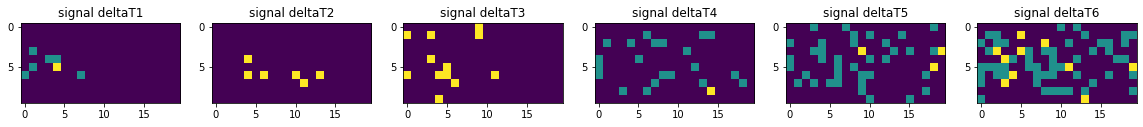

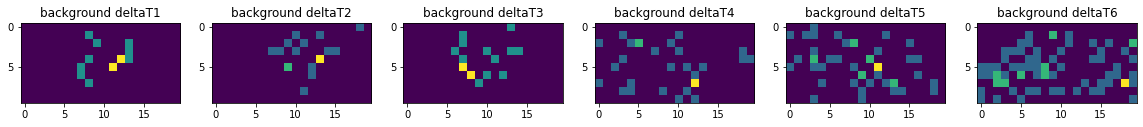

In [39]:
signal = images[labels == 1]
background = images[labels == 0]

sig = np.random.randint(0, signal.shape[0])
back = np.random.randint(0, background.shape[0])

plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(signal[sig][:, :, i])
  plt.title(f'signal deltaT{i+1}')
plt.show()
plt.figure(figsize=(20, 10))
for i in range(6):
  plt.subplot(1, 6, i+1)
  plt.imshow(background[back][:, :, i])
  plt.title(f'background deltaT{i+1}')
plt.show()

# NN training

In [0]:
from sklearn.model_selection import train_test_split
(X_train, X_test, Y_train, Y_test) = train_test_split(images, labels, test_size=0.1)

In [0]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [42]:
print(X_train.shape)
print(Y_train.shape)

(72000, 10, 20, 6)
(72000,)


In [240]:
IMG_SHAPE = (10, 20, 6)

img_input = keras.Input(shape=IMG_SHAPE, name="D_Image_Input")
x = img_input

# primo blocco Convoluzionale
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 5),name='Conv_1')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_1')(x)
x = layers.Dropout(0.1, name="DropOut_1")(x)
#x = keras.layers.MaxPool2D((2,2), name='MaxPool_1', padding='same')(x)

# secondo blocco Convoluzionale
x = keras.layers.Conv2D(filters=64, kernel_size=(3, 4), name='Conv_2')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_2')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_2', padding='same')(x)
x = layers.Dropout(0.1, name="DropOut_2")(x)

# terzo blocco Convoluzionale
x = keras.layers.Conv2D(filters=64, kernel_size=(2, 3), name='Conv_3')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU(name='ReLU_3')(x)
x = keras.layers.MaxPool2D((2,2), name='MaxPool_1', padding='same')(x)
x = layers.Dropout(0.12, name="DropOut_3")(x)

x = keras.layers.Flatten(name='Flatten')(x)

# layer densi
x = keras.layers.Dense(128, name='Dense_1')(x)
x = layers.Dropout(0.2, name="DropOut_4")(x)
x = keras.layers.ReLU(name='ReLU_dense_1')(x)

x = keras.layers.Dense(256, name='Dense_2')(x)
x = layers.Dropout(0.2, name="DropOut_5")(x)
x = keras.layers.ReLU(name='ReLU_dense_2')(x)

outputs = keras.layers.Dense(1, activation='sigmoid', name='Output')(x)

model = keras.Model(inputs=img_input, outputs=outputs, name='predictor')

#printout il summary del modello
model.summary()

Model: "predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
D_Image_Input (InputLayer)   [(None, 10, 20, 6)]       0         
_________________________________________________________________
Conv_1 (Conv2D)              (None, 8, 16, 32)         2912      
_________________________________________________________________
batch_normalization_176 (Bat (None, 8, 16, 32)         128       
_________________________________________________________________
ReLU_1 (ReLU)                (None, 8, 16, 32)         0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 8, 16, 32)         0         
_________________________________________________________________
Conv_2 (Conv2D)              (None, 6, 13, 64)         24640     
_________________________________________________________________
batch_normalization_177 (Bat (None, 6, 13, 64)         25

In [241]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath='cnn_best',
        monitor='val_accuracy',
        save_weights_only=True, 
        save_best_only=True,
        save_freq='epoch')

# metto tutte le callback in una lista
callbacks = [ model_checkpoint ]     

model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
history = model.fit(X_train, Y_train, validation_split=0.1, batch_size=256, 
          epochs=30, shuffle=True, verbose=1, callbacks=callbacks)

Epoch 1/30
254/254 [==============================] - 4s 15ms/step - loss: 0.5962 - accuracy: 0.6788 - val_loss: 0.5617 - val_accuracy: 0.7358
Epoch 2/30
254/254 [==============================] - 4s 14ms/step - loss: 0.5350 - accuracy: 0.7346 - val_loss: 0.5297 - val_accuracy: 0.7369
Epoch 3/30
254/254 [==============================] - 3s 13ms/step - loss: 0.5175 - accuracy: 0.7474 - val_loss: 0.5012 - val_accuracy: 0.7564
Epoch 4/30
254/254 [==============================] - 3s 13ms/step - loss: 0.5052 - accuracy: 0.7567 - val_loss: 0.5109 - val_accuracy: 0.7487
Epoch 5/30
254/254 [==============================] - 3s 13ms/step - loss: 0.4957 - accuracy: 0.7635 - val_loss: 0.4905 - val_accuracy: 0.7646
Epoch 6/30
254/254 [==============================] - 3s 14ms/step - loss: 0.4883 - accuracy: 0.7671 - val_loss: 0.4886 - val_accuracy: 0.7685
Epoch 7/30
254/254 [==============================] - 3s 13ms/step - loss: 0.4796 - accuracy: 0.7741 - val_loss: 0.5030 - val_accuracy: 0.7625

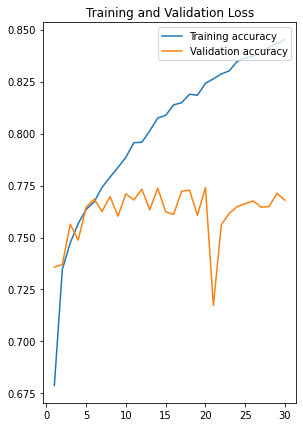


acc:0.7736250162124634


In [242]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']

epochs_range = range(1, len(accuracy) + 1)

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label='Training accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

model.load_weights('cnn_best')
vali_loss, vali_acc = model.evaluate(X_test, Y_test, verbose=0)
print(f'\nacc:{vali_acc}')